<a href="https://colab.research.google.com/github/Michwynn/London-Airbnb-Analysis---2/blob/Michael/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# set up working directory
import os
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Airbnb_Milestone2

# data manipulation
import pandas as pd
import numpy as np 
from tqdm import tqdm

# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, fbeta_score, jaccard_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

# Plot ROC AUC Curve & Visualisation
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, PrecisionRecallCurve

import matplotlib.pyplot as plt
%matplotlib inline



# supress warnings
import warnings 
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1wUOfFY-ki2nFzneeaTtXLEeMjaSdKrrj/Airbnb_Milestone2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Configuration**

In [60]:
%%time

RANDOM_SEED = 42
fractions = np.array([0.8, 0.1, 0.1])
cleaned_df = pd.read_csv('Datasets/cleaned_df.csv', lineterminator = '\n') # reading the datasest

# Data pre-processing using conventional method (ok accuracy / fast speed)
def clean_text(comments):
  punc = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
  punc_removed = [char for char in comments if char not in punc]
  punc_join = ''.join(punc_removed)
  cleaned = []
  splitted = punc_join.split()
  for x in splitted:
    if x.isalpha() and x not in stop_words:
      cleaned.append(x.lower())
  result = ' '.join(cleaned)
  return result

cleaned_df['cleaned_comments'] = cleaned_df['comments'].apply(clean_text)

# TfidfVectorizer:
min_df = 25

# Logistic Regression:
solver = 'lbfgs'
multi_class = 'auto'

# RF & Adaboost:
n_estimators = 10
max_depth = 3

# K Nearest Neighbour:
k = 3

CPU times: user 54.9 s, sys: 1.71 s, total: 56.6 s
Wall time: 1min 4s


**Downsampling method for imbalance dataset**

In [61]:
cleaned_df['sentiment'].value_counts()

Positive    1045528
Neutral       25786
Negative      16185
Name: sentiment, dtype: int64

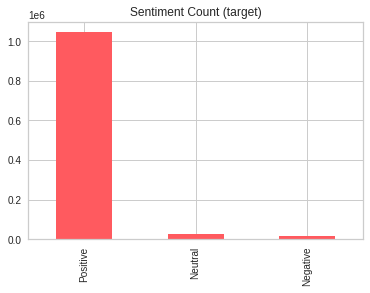

In [62]:
cleaned_df['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title = 'Sentiment Count (target)')

class_positive: (1045528, 14)
class_neutral: (25786, 14)
class_negative: (16185, 14)
Random Under Sampling leads to.........


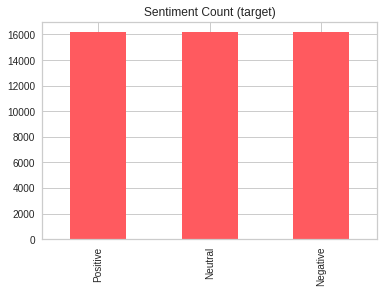

In [63]:
# class count
class_count_positive, class_count_neutral, class_count_negative = cleaned_df['sentiment'].value_counts()


# Separate sentiment into each df
class_positive = cleaned_df[cleaned_df['sentiment'] == "Positive"]
class_neutral = cleaned_df[cleaned_df['sentiment'] == "Neutral"]
class_negative = cleaned_df[cleaned_df['sentiment'] == "Negative"]

print('class_positive:', class_positive.shape)
print('class_neutral:', class_neutral.shape)
print('class_negative:', class_negative.shape)
print("Random Under Sampling leads to.........")
      
# As negative sentiment is the lowest case count, we will do random undersampling for both positive and neutral sentiments to get an equally distributed and balanced dataset
class_positive_under = class_positive.sample(class_count_negative, random_state = RANDOM_SEED)
class_neutral_under = class_neutral.sample(class_count_negative, random_state = RANDOM_SEED)

# Combine all dataframes
cleaned_df_undersampling = pd.concat([class_positive_under, class_neutral_under, class_negative], axis = 0)
cleaned_df_undersampling['sentiment'].value_counts().plot(kind = 'bar', color = '#FF5A5F', title ='Sentiment Count (target)')

In [64]:
#cleaned_df_undersampling.to_csv('cleaned_df_undersampling.csv')

**Split datasets into train, validation and test sets**

We have a large enough dataset that we can effectively split it into train, development, and test sets, using the standard ratio of 80%, 10%, 10% for each, respectively.

In [65]:
def get_train_val_test(df, fractions, RANDOM_SEED):

  # Get the required input and target variables from dataframe and drop NA rows:
  df = df[['cleaned_comments','sentiment']].dropna()
  # shuffling the data:
  df = df.sample(frac = 1, random_state = RANDOM_SEED)
  # split into training, validation and testing sets
  train_df, val_df, test_df = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))

  if len(train_df) + len(val_df) + len(test_df) != len(df):
    print("Check the splitting method!")
  else:
    return train_df, val_df, test_df

**Splitting...**

In [66]:
train_df, val_df, test_df = get_train_val_test(cleaned_df_undersampling, fractions, RANDOM_SEED)

**Convert text data to features - TF-IDF and get target input**

In [67]:
%%time
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = min_df, norm ='l2')
X_train = vectorizer.fit_transform(train_df.cleaned_comments)
y_train = list(train_df.sentiment)

CPU times: user 1.09 s, sys: 27.9 ms, total: 1.12 s
Wall time: 1.39 s


**Fit the classifier on the data**

In [68]:
%%time
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_log.fit(X_train, y_train)

CPU times: user 1.91 s, sys: 21 ms, total: 1.93 s
Wall time: 1.95 s


LogisticRegression(random_state=42)

**Generate validation data**

In [69]:
%%time
X_val = vectorizer.transform(val_df.cleaned_comments)
y_val = list(val_df.sentiment)

CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 112 ms


**Generate logistic regression (baseline model) prediction**

Logistic regression is a good model because it trains quickly even on large datasets and provides very robust results. Other good model choices include SVMs, Random Forests, and Naive Bayes.

In [70]:
%%time
lr_pred = clf_log.predict(X_val)
lr_f1 = f1_score(y_val, lr_pred, average = 'macro')
print("F1 score for baseline regression:", lr_f1)

F1 score for baseline regression: 0.9173549143464004
CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 24.7 ms


**Comparing all classification models**

In [13]:
clf_log = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)
clf_svm = svm.SVC(decision_function_shape = 'ovr', probability = True, random_state = RANDOM_SEED)
clf_svm_ = svm.SVC(decision_function_shape = 'ovr', random_state = RANDOM_SEED) # without probability = True
clf_nb = MultinomialNB()
clf_dt = tree.DecisionTreeClassifier(random_state = RANDOM_SEED)
clf_rf = RandomForestClassifier(random_state = RANDOM_SEED)
clf_gbc = GradientBoostingClassifier(random_state = RANDOM_SEED)
clf_boost = AdaBoostClassifier(random_state = RANDOM_SEED)
clf_xtratree = ExtraTreesClassifier(random_state = RANDOM_SEED)
clf_knn = KNeighborsClassifier(n_neighbors = k)

model_names = ["LogisticRegression (Base)", "SupportVectorMachine", "MultinomialNB", "DecisionTreeClassifier", 
               "RandomForestClassifier", "GradientBoostingClassifier", "AdaBoostClassifier", "ExtraTreesClassifier", "KNeighborsClassifier"]

model_list = [clf_log, clf_svm, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]
model_list_ = [clf_log, clf_svm_, clf_nb, clf_dt, clf_rf, clf_gbc, clf_boost, clf_xtratree, clf_knn]

In [15]:
accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in tqdm(model_list):
  model.fit(X_train, y_train)
  model_predict = model.predict(X_val)
  accuracy.append(accuracy_score(model_predict, y_val))
  precision.append(precision_score(model_predict, y_val, average = 'macro'))
  recall.append(recall_score(model_predict, y_val, average = 'macro'))
  f1score.append(f1_score(model_predict, y_val, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_val, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_val, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_val, model.predict_proba(X_val), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_val, model.predict_proba(X_val)))

100%|██████████| 9/9 [33:53<00:00, 225.95s/it]


In [41]:
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision (Macro),Recall (Macro),F1 Score (Macro),Jaccard Score (Macro),F-beta Score (Macro),AUC ROC Score,Log Loss
0,LogisticRegression (Base),0.917405,0.917423,0.917317,0.917355,0.848002,0.917392,0.978716,0.275187
1,SupportVectorMachine,0.918023,0.918027,0.918937,0.918316,0.849698,0.918102,0.978504,0.264870
2,MultinomialNB,0.805973,0.804541,0.837003,0.800854,0.669427,0.799297,0.965882,0.464833
3,DecisionTreeClassifier,0.844902,0.845106,0.844760,0.844843,0.735042,0.844980,0.872303,5.192471
4,RandomForestClassifier,0.897425,0.897350,0.898024,0.897460,0.815336,0.897339,0.971416,0.356477
5,GradientBoostingClassifier,0.877240,0.877357,0.876875,0.876360,0.781339,0.876778,0.965765,0.409064
6,AdaBoostClassifier,0.845726,0.845793,0.847777,0.842631,0.731398,0.843556,0.861810,1.019145
7,ExtraTreesClassifier,0.904840,0.904783,0.905709,0.905083,0.827693,0.904864,0.972824,0.379646
8,KNeighborsClassifier,0.413182,0.416243,0.624552,0.327113,0.208028,0.351120,0.580612,18.465690


**ROC-AUC Curve plots**

In [47]:
def plot_ROC_curve(model, X_train, y_train, X_val, y_val):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder = {'Positive': 'Positive', 
                                          'Neutral': 'Neutral', 
                                          'Negative': 'Negative'},
                        fig = plt.figure(figsize=(8,5)))
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

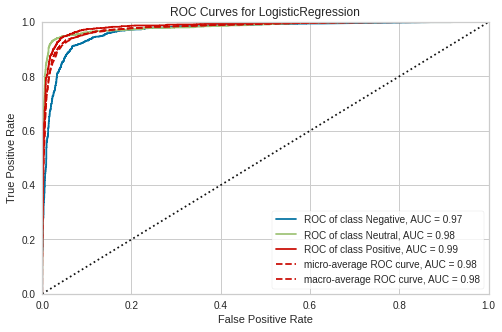

 11%|█         | 1/9 [00:00<00:02,  3.78it/s]

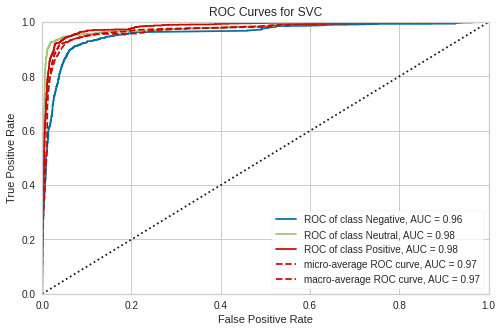

 22%|██▏       | 2/9 [06:40<27:27, 235.32s/it]

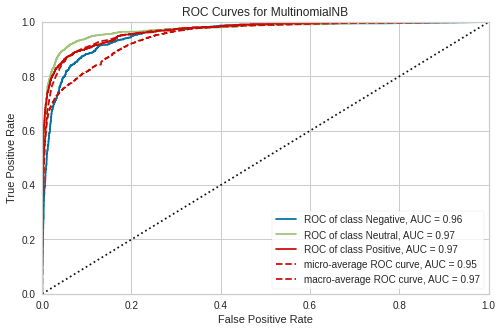

 33%|███▎      | 3/9 [06:40<12:48, 128.01s/it]

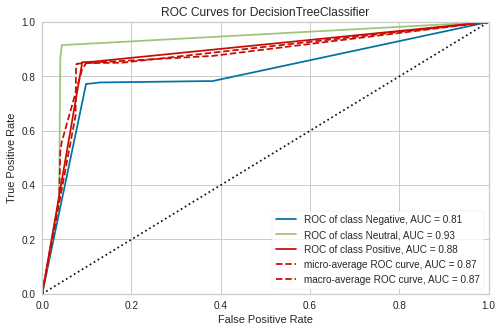

 44%|████▍     | 4/9 [06:53<06:53, 82.61s/it] 

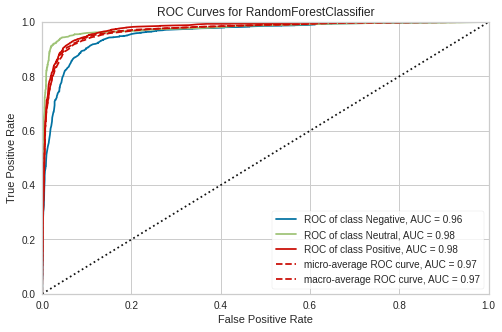

 56%|█████▌    | 5/9 [07:52<04:56, 74.15s/it]

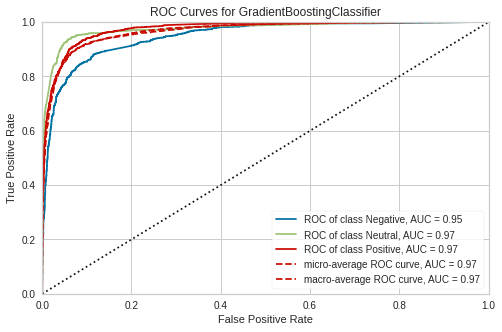

 67%|██████▋   | 6/9 [09:10<03:45, 75.32s/it]

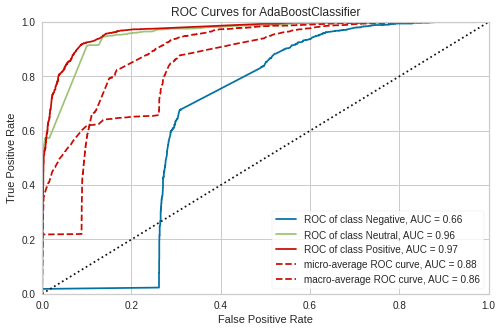

 78%|███████▊  | 7/9 [09:17<01:46, 53.04s/it]

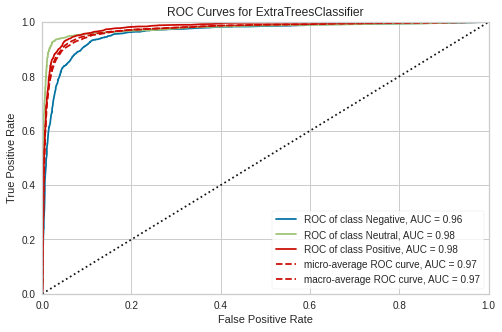

 89%|████████▉ | 8/9 [10:32<01:00, 60.14s/it]

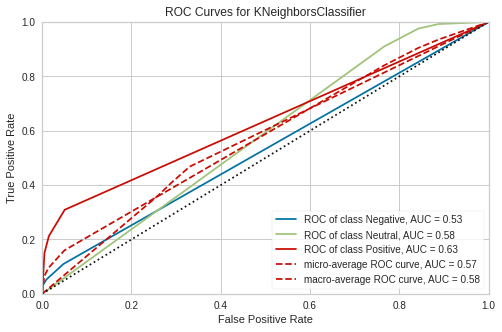

100%|██████████| 9/9 [10:46<00:00, 71.88s/it]


In [49]:
for model in tqdm(model_list_):
  plot_ROC_curve(model, X_train, y_train, X_val, y_val)

In [50]:
def plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val):

    classes = ['Positive', 'Neutral', 'Negative']
    visualizer = ConfusionMatrix(
        model, classes = classes,
        percent = True,
        label_encoder = {'Positive': 'Positive', 
                         'Neutral': 'Neutral', 
                         'Negative': 'Negative'},
        fig = plt.figure(figsize=(8,5)))

    visualizer.fit(X_train, y_train)
    visualizer.score(X_val, y_val)
    visualizer.show()
    
    return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

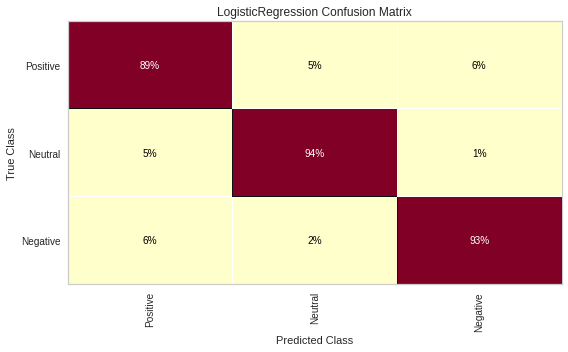

 11%|█         | 1/9 [00:00<00:01,  5.07it/s]

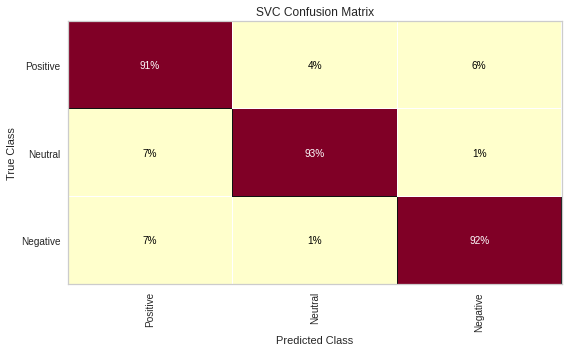

 22%|██▏       | 2/9 [00:29<02:03, 17.59s/it]

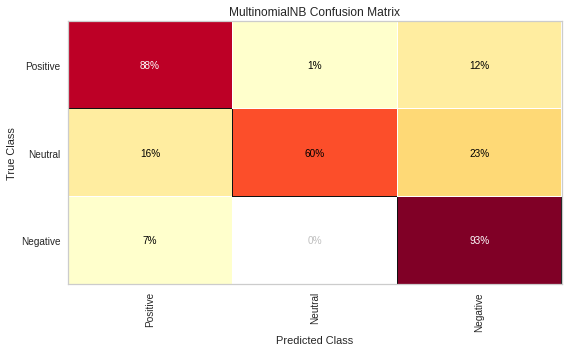

 33%|███▎      | 3/9 [00:30<00:57,  9.64s/it]

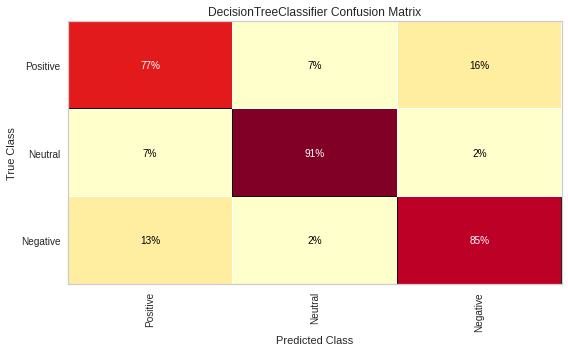

 44%|████▍     | 4/9 [00:30<00:29,  5.91s/it]

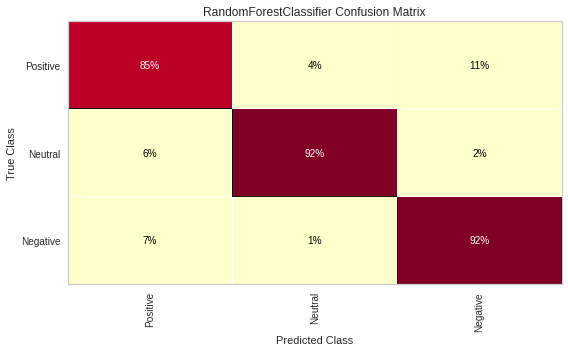

 56%|█████▌    | 5/9 [00:31<00:16,  4.03s/it]

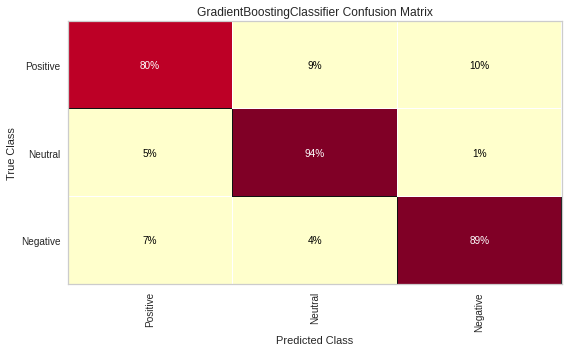

 67%|██████▋   | 6/9 [00:31<00:08,  2.74s/it]

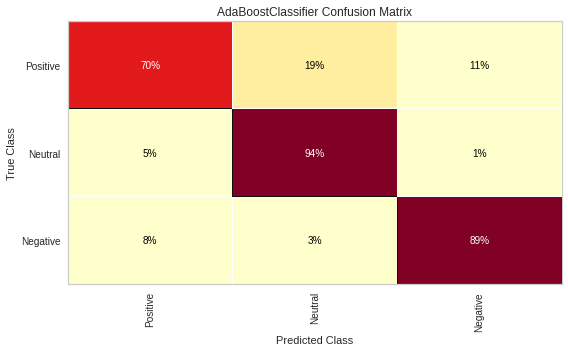

 78%|███████▊  | 7/9 [00:31<00:03,  1.95s/it]

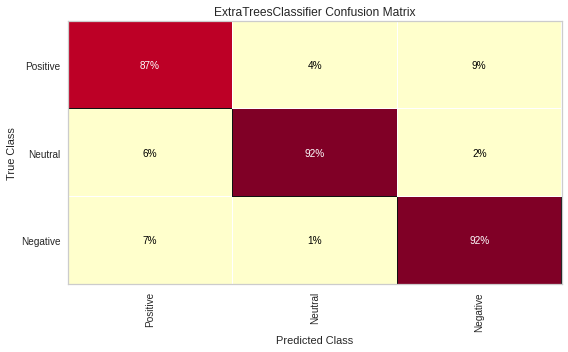

 89%|████████▉ | 8/9 [00:32<00:01,  1.61s/it]

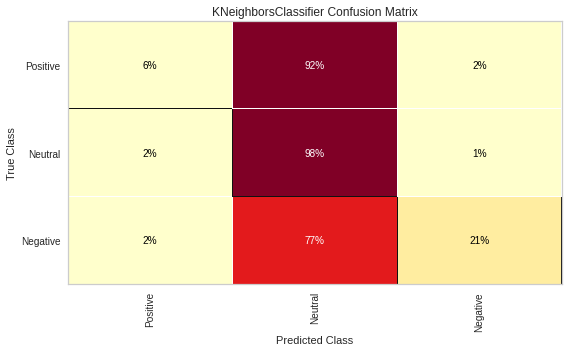

100%|██████████| 9/9 [00:42<00:00,  4.77s/it]


In [51]:
for model in tqdm(model_list_):
  plot_Confusion_Matrix_Heatmap(model, X_train, y_train, X_val, y_val)

**Precision-Recall Curve**

In [52]:
def precision_recall_curve_plot(model, X_train, y_train, X_val, y_val):
  visualizer = PrecisionRecallCurve(model, per_class = True, fill_area = False, iso_f1_curves = True, fig = plt.figure(figsize=(8,5)))
  visualizer.fit(X_train, y_train)
  visualizer.score(X_val, y_val)
  visualizer.show()
  return visualizer

  0%|          | 0/9 [00:00<?, ?it/s]

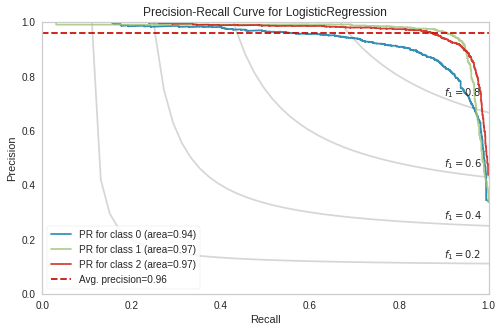

 11%|█         | 1/9 [00:02<00:17,  2.19s/it]

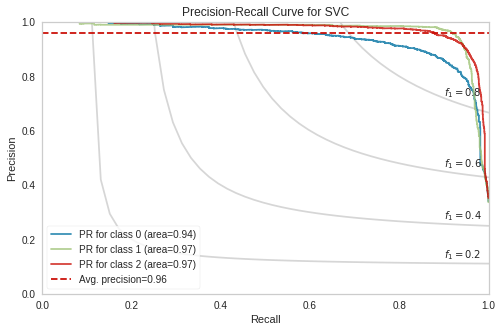

 22%|██▏       | 2/9 [14:36<1:00:07, 515.37s/it]

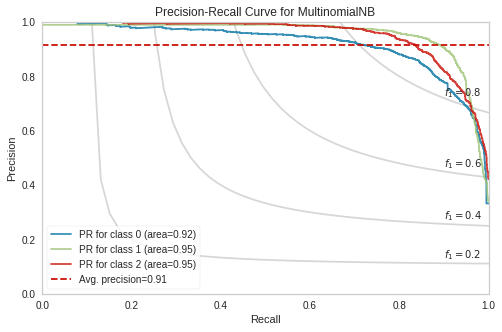

 33%|███▎      | 3/9 [14:37<28:01, 280.25s/it]  

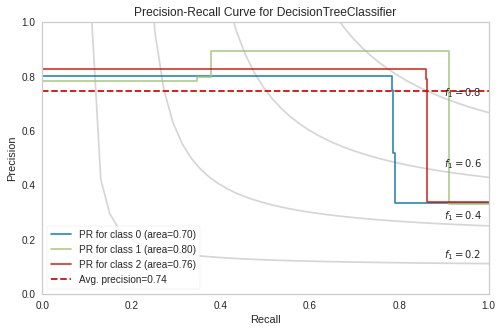

 44%|████▍     | 4/9 [15:16<15:26, 185.28s/it]

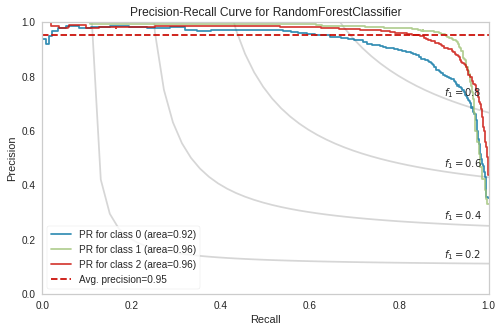

 56%|█████▌    | 5/9 [17:33<11:11, 167.76s/it]

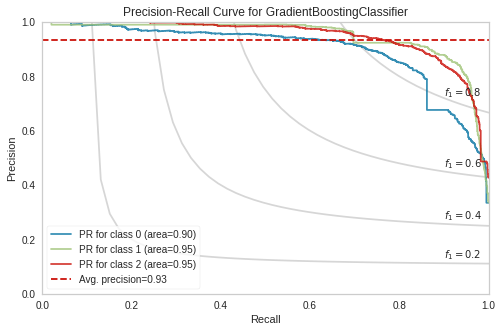

 67%|██████▋   | 6/9 [18:47<06:47, 135.68s/it]

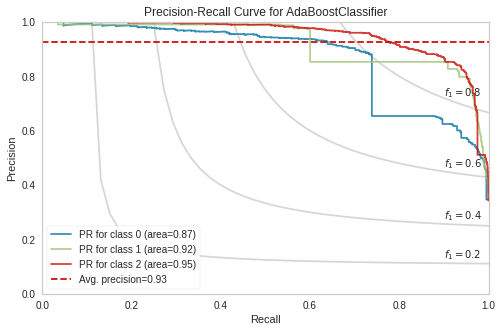

 78%|███████▊  | 7/9 [19:05<03:14, 97.40s/it] 

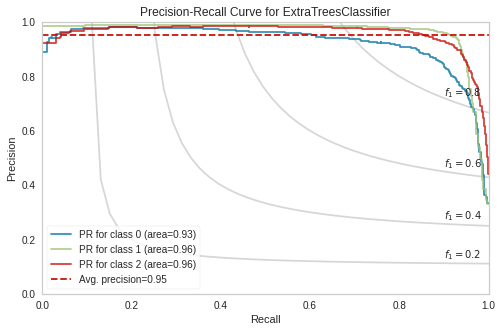

 89%|████████▉ | 8/9 [22:04<02:03, 123.32s/it]

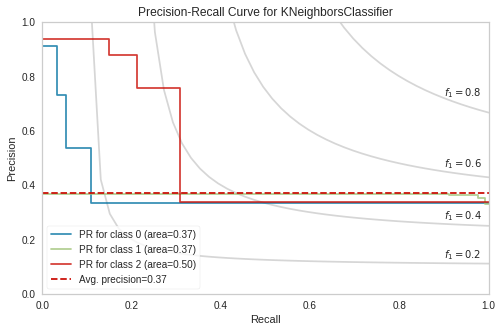

100%|██████████| 9/9 [22:39<00:00, 151.09s/it]


In [53]:
for model in tqdm(model_list_):
  precision_recall_curve_plot(model, X_train, y_train, X_val, y_val)

**Hyperparameter Tuning - RandomizedSearchCV**

In the hyperparameter tuning, instead of picking all models, we decide to perform the tuning for the top three models through a randomized search with cross-validation. The top three models are picked based on overall performance of the evaluation metrics. The primary aim was to improve a particular
evaluation metric for each of these model by choosing the scoring methods as follows:

1. KneighborsClassifier: F1 score
2. AdaBoostClassifier
3. GradientBoostingClassifier

Multinomial - no hyperparameters to tune

**LogisticRegression**

In [39]:
from sklearn.model_selection import RandomizedSearchCV

model = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED)

# define search space
space = dict()
space['solver'] = ['lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.001, 0.01, 0.1, 1, 10]
space['multi_class'] = ['auto', 'ovr']

# Create an instance of GridSearch Cross-validation estimator
search = RandomizedSearchCV(model, space, n_iter = 100, scoring = 'f1_macro', random_state = RANDOM_SEED)

# execute search
result = search.fit(X_train, y_train)
result.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'auto', 'C': 1}

In [85]:
%%timeit
X_test = vectorizer.transform(test_df.cleaned_comments)
y_test = list(test_df.sentiment)

111 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
model_default = LogisticRegression(multi_class = multi_class, random_state = RANDOM_SEED).fit(X_train, y_train)
model_tuned = clf_log_tuned = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', multi_class = 'auto', random_state = RANDOM_SEED).fit(X_train, y_train).fit(X_train, y_train)

evaluation_models = [model_default, model_tuned]

accuracy = []
precision = []
recall = []
f1score = []
jaccard = []
fbeta = []
roc_auc = []
logloss_ = []

for model in evaluation_models:
  model_predict = model.predict(vectorizer.transform(test_df.cleaned_comments))
  accuracy.append(accuracy_score(model_predict, y_test))
  precision.append(precision_score(model_predict, y_test, average = 'macro'))
  recall.append(recall_score(model_predict, y_test, average = 'macro'))
  f1score.append(f1_score(model_predict, y_test, average = 'macro'))
  jaccard.append(jaccard_score(model_predict, y_test, average = 'macro'))
  fbeta.append(fbeta_score(model_predict, y_test, average = 'macro', beta = 0.5))
  roc_auc.append(roc_auc_score(y_test, model.predict_proba(vectorizer.transform(test_df.cleaned_comments)), multi_class = 'ovr', average = 'macro'))
  logloss_.append(log_loss(y_test, model.predict_proba(vectorizer.transform(test_df.cleaned_comments))))

model_names = ["LogisticRegression (Default)", "LogisticRegression (Tuned)"]
pd.DataFrame(list(zip(model_names, accuracy, precision, recall, f1score, jaccard, fbeta, roc_auc, logloss_)),
               columns =['Classifier', 'Accuracy (Balanced)', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)', 'Jaccard Score (Macro)', 'F-beta Score (Macro)', 'AUC ROC Score', 'Log Loss'])

,Classifier,Accuracy (Balanced),Precision (Macro),Recall (Macro),F1 Score (Macro),Jaccard Score (Macro),F-beta Score (Macro),AUC ROC Score,Log Loss
0,LogisticRegression (Default),0.912685,0.912117,0.912303,0.912186,0.839338,0.912139,0.978955,0.277033
1,LogisticRegression (Tuned),0.914951,0.914150,0.914344,0.914189,0.842871,0.914152,0.977672,0.285883
